In [1]:
# import internal files
import emulators
import sample
import historymatch
import plot

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy import stats

plt.rcParams.update({'font.size': 10})

np.random.seed(4)

import importlib

In [2]:
def model_eqn_1(x, theta_0, theta_1, theta_2):
    return theta_0 + theta_1*(x) + theta_2*(x**2)

function1 = np.vectorize(model_eqn_1)

In [3]:
def model_eqn_2(x, theta_0, theta_1, theta_2):
    return theta_0 - theta_1*np.sin(x) + (theta_2**1)*np.cos(x)

function2 = np.vectorize(model_eqn_2)

In [4]:
# define parameter space
var_method = 0.01

theta_0_bound = np.array([-1, 1]).reshape(1,-1)
theta_1_bound = np.array([-1, 1]).reshape(1,-1)
theta_2_bound = np.array([-1, 1]).reshape(1,-1)

parameter_bounds = np.concatenate((theta_0_bound, theta_1_bound, theta_2_bound), axis=0)

theta_0_vals = np.linspace(parameter_bounds[0,0], parameter_bounds[0,1], 100)
theta_1_vals = np.linspace(parameter_bounds[1,0], parameter_bounds[1,1], 100)
theta_2_vals = np.linspace(parameter_bounds[2,0], parameter_bounds[2,1], 100)

theta_vals = np.concatenate((theta_0_vals.reshape(1,-1), theta_1_vals.reshape(1,-1), theta_2_vals.reshape(1,-1)), axis=0)

In [5]:
Nx = 8

def toy_model(theta_0, theta_1, theta_2):
    
    x_bound = np.array([0.1, 1])
    Nx = 8
    xvals = np.linspace(x_bound[0], x_bound[-1], Nx)

    outputs =  []
    for x in xvals:
        output = theta_0 + (theta_1**1)*(x) + theta_2*(x**2)
        outputs.append(output)
    for x in xvals:
        output = theta_0 - theta_1*np.sin(x) + (theta_2**1)*np.cos(x)
        outputs.append(output)
    return np.array(outputs)

In [6]:
# generate observational data with some uncertainty
true_parameters = [-0.1, 0.3, 0.6]

#output_ratio = (toy_model(-1,-1,-1) - toy_model(1,1,1)) / (toy_model(-1,-1,-1) - toy_model(1,1,1))[0]

#var_obs = output_ratio*0.01 # observational uncertainty variance


#error_obs = np.zeros(2*Nx)
#for i in range(2*Nx):
    #error_obs[i] = np.random.normal(0, np.sqrt(var_obs[i]))


#obs_data = toy_model_4D(*true_parameters_4D) + error_obs




var_obs = np.ones(2*Nx)*0.01 # observational uncertainty variance

error_obs = np.random.normal(0, np.sqrt(var_obs), 2*Nx)

obs_data = toy_model(*true_parameters) + error_obs


In [7]:
nwaves = 3
ndim = 3

In [8]:
importlib.reload(historymatch)

# initialise history matching class
HM = historymatch.HistoryMatch(obs_data,
                               ndim, 'GP', 'ellipsoid')

In [9]:


ToyModel = historymatch.Simulator(HM)
ToyModel.set_simulator(toy_model)

HM.set_observations(obs_data, np.sqrt(var_obs))
HM.initialize_volume([-1,-1,-1], [1,1,1])

results = HM.run(nwaves=nwaves)

(3, 2)
(3, 2)
Running wave 1
Emulating...
[0.01560712 0.01231947 0.01514028 ... 0.01023211 0.01515396 0.0153347 ]
Mean emulator s.d lower than obs
Emulating...
[0.0157133  0.01239253 0.01527287 ... 0.01029065 0.01525896 0.01545909]
Mean emulator s.d lower than obs
Emulating...
[0.01595478 0.01255661 0.01557468 ... 0.01042189 0.0154948  0.0157401 ]
Mean emulator s.d lower than obs
Emulating...
[0.01636418 0.01282841 0.01608683 ... 0.01063844 0.01588549 0.01621062]
Mean emulator s.d lower than obs
Emulating...
[0.01698169 0.01322397 0.01685945 ... 0.01095145 0.01645437 0.0169069 ]
Mean emulator s.d lower than obs
Emulating...
[0.01784688 0.01375173 0.01793997 ... 0.01136446 0.01721467 0.01785759]
Mean emulator s.d lower than obs
Emulating...
[0.01899272 0.0144102  0.01936387 ... 0.01187094 0.01816664 0.01907802]
Mean emulator s.d lower than obs
Emulating...
[0.02044351 0.01519172 0.02115138 ... 0.01245706 0.0193032  0.0205721 ]
Mean emulator s.d lower than obs
Emulating...
[0.01861395 0.

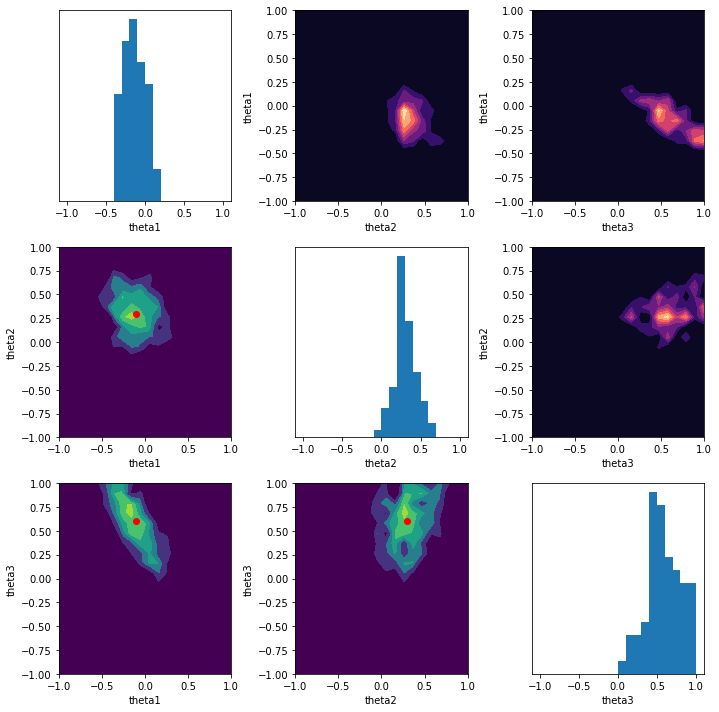

In [15]:
importlib.reload(plot)

fig, axes = plt.subplots(ndim,ndim,figsize=(10,10))
#plot.opticaldepth_1D(results.samples[0], parameter_bounds[0], parameter = 0, bins=20, Fig=(fig,ax1))
    
#plot.plot_implausibility2D(results.samples[0], parameter_bounds, [0,1], bins=20)

plot.plotcorner(results.samples[2], parameter_bounds, 3, Fig=(fig,axes), labels=('theta1', 'theta2', 'theta3'))
axes[1,0].scatter(true_parameters[0],true_parameters[1], color='red')
axes[2,0].scatter(true_parameters[0],true_parameters[2], color='red')
axes[2,1].scatter(true_parameters[1],true_parameters[2], color='red')

In [16]:
results.samples[1].shape

(5000, 4)

In [18]:
with open('data/3D_historymatch_ellipsoid_8z_test.txt', 'w') as file:
    for i in range(len(results.samples)):
        np.savetxt(file, results.samples[i])



analytic_mean = np.loadtxt("3D_analytic_mean.txt").reshape(3,)
analytic_cov = np.loadtxt("3D_analytic_cov.txt").reshape(3,3)

print(analytic_cov)

[[ 0.00500388 -0.00037699 -0.00613499]
 [-0.00037699  0.00342433  0.00045998]
 [-0.00613499  0.00045998  0.01003366]]


In [13]:
def get_cov_ellipse(cov, centre, nstd, ax, color):
    """
    Return a matplotlib Ellipse patch representing the covariance matrix
    cov centred at centre and scaled by the factor nstd.

    """

    # Find and sort eigenvalues and eigenvectors into descending order
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    # The anti-clockwise angle to rotate our ellipse by 
    vx, vy = eigvecs[:,0][0], eigvecs[:,0][1]
    theta = np.arctan2(vy, vx)

    # Width and height of ellipse to draw
    width, height = 2 * nstd * np.sqrt(np.abs(eigvals))
    
    t = np.linspace(0, 2*np.pi, 100)
    Ell = np.array([0.5*width*np.cos(t) , 0.5*height*np.sin(t)]) 
    R_rot = np.array([[np.cos(theta) , -np.sin(theta)],[np.sin(theta), np.cos(theta)]])  
    Ell_rot = np.zeros((2,Ell.shape[1]))
    for i in range(Ell.shape[1]):
        Ell_rot[:,i] = np.dot(R_rot,Ell[:,i])
    
    ax.plot( centre[0]+Ell_rot[0,:] , centre[1]+Ell_rot[1,:], color=color)

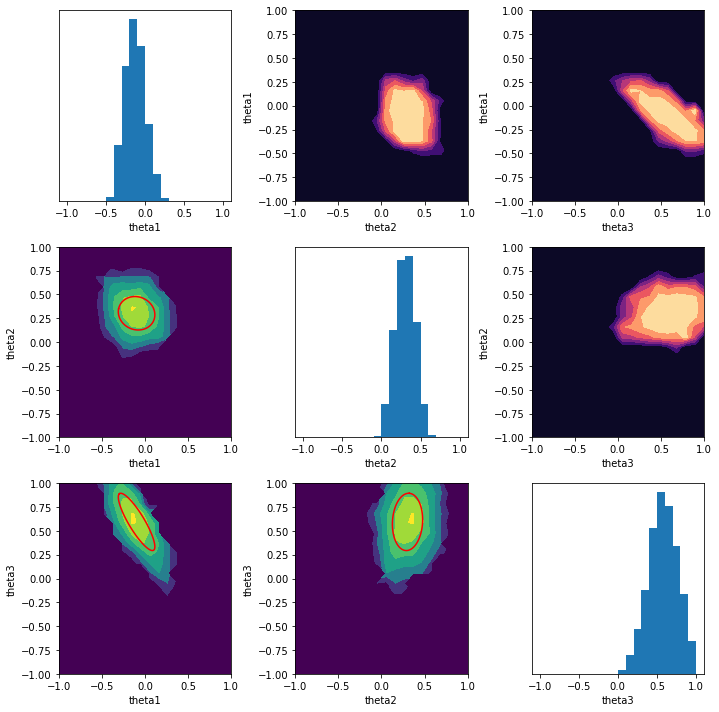

In [14]:
fig, axes = plt.subplots(ndim,ndim,figsize=(10,10))
#plot.opticaldepth_1D(results.samples[0], parameter_bounds[0], parameter = 0, bins=20, Fig=(fig,ax1))
    
#plot.plot_implausibility2D(results.samples[0], parameter_bounds, [0,1], bins=20)

plot.plotcorner(results.samples[1], parameter_bounds, 3, Fig=(fig,axes), labels=('theta1', 'theta2', 'theta3'))

H = analytic_cov

get_cov_ellipse(np.array([[H[0,0], H[0,1]],[H[1,0], H[1,1]]]), [analytic_mean[0], analytic_mean[1]], 3, axes[1,0], 'red')
get_cov_ellipse(np.array([[H[0,0], H[0,2]],[H[2,0], H[2,2]]]), [analytic_mean[0], analytic_mean[2]], 3, axes[2,0], 'red')
get_cov_ellipse(np.array([[H[1,1], H[1,2]],[H[2,1], H[2,2]]]), [analytic_mean[1], analytic_mean[2]], 3, axes[2,1], 'red')


#axes[1,0].scatter(true_parameters[0],true_parameters[1], color='red')
#axes[2,0].scatter(true_parameters[0],true_parameters[2], color='red')
#axes[2,1].scatter(true_parameters[1],true_parameters[2], color='red')